<a href="https://colab.research.google.com/github/alessio76/Progetto-ML/blob/main/Neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split
from matplotlib import pyplot
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV
import json
from google.colab import files
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
import copy
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix
import os
import time

In [9]:
import tensorflow as tf
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.python.client import device_lib
print('Tensorflow Version', tf.__version__)
print ("\nHardware Devices:")
print (device_lib.list_local_devices())
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Nasconde messaggi di debug

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-q3g64412
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-q3g64412
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0d1c17eec9b02a8c850e256500bd7c5f63fc8fad1_-py3-none-any.whl size=157216 sha256=cde8eeeafb1bef33d5116d7339ae6d26b9eb66bca984b65b73fb00560f1f4688
  Stored in directory: /tmp/pip-ephem-wheel-cache-m1x3mpxq/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Tensorflow Version 2.6.0

Hardware Devices:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality

In [ ]:
def build_model(activation_hidden='relu', activation_output = 'softmax', init_mode='uniform', learning_rate=0.01, momentum=0, optimizer='SGD', n_neurons = 10, 
                loss = 'sparse_categorical_crossentropy', regularization = None):
   n_features = x.shape[1]
   n_classes = 2
   model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_features, activation=activation_hidden, input_shape = [n_features]),                        
        tf.keras.layers.Dense(n_neurons, activation=activation_hidden, kernel_regularizer= regularization),
        tf.keras.layers.Dense(n_classes, activation=activation_output)
    ])
   
   if optimizer == 'SGD':
         optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)


   model.compile(loss=loss, optimizer=optimizer, metrics = 'accuracy')
   return model

In [5]:
def build_model_n_layer(activation_hidden='relu', activation_output = 'softmax', init_mode='uniform', learning_rate=0.01, momentum=0, optimizer='SGD', n_neurons = 10, 
                loss = 'sparse_categorical_crossentropy', regularization = None, n_layers = 1):
   n_features = x.shape[1]
   n_classes = 2
   hidden_layers = list()

   for i in range(1,n_layers+1):
     layer = tf.keras.layers.Dense(n_neurons, activation=activation_hidden, kernel_regularizer= regularization)
     hidden_layers.append(layer)
     
   first_layer = [tf.keras.layers.Dense(n_features, activation=activation_hidden, input_shape = [n_features])]
   last_layer = [tf.keras.layers.Dense(n_classes, activation=activation_output)]            
   total_layers = first_layer + hidden_layers + last_layer                          
   model = tf.keras.Sequential(total_layers)
  
   if optimizer == 'SGD':
         optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)


   model.compile(loss=loss, optimizer=optimizer, metrics = 'accuracy')
   return model

In [40]:
def grid_search(param_grid, trainig_set, training_labels, model):
  start = time.time()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
  grid_result = grid.fit(trainig_set, training_labels)
  print('\nTraining MLP completato in %.2f s.' % (time.time() - start))
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  return grid_result.best_params_, grid_result.best_score_

In [17]:
def scoring(train_x, train_y, test_x, test_y, model):
  y_pred_test, y_pred_train = model.predict(test_x), model.predict(train_x)
  y_pred_test, y_pred_train = transform_y_pred(y_pred_test), transform_y_pred(y_pred_train)
  compute_precision, compute_recall = tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
  compute_precision.update_state(train_y, y_pred_train)
  compute_recall.update_state(train_y, y_pred_train)
  train_precision, train_recall = compute_precision.result(), compute_recall.result()

  compute_precision.update_state(test_y, y_pred_test)
  compute_recall.update_state(test_y, y_pred_test)
  test_precision, test_recall = compute_precision.result(), compute_recall.result()

  print("Train:", "Precision = ",train_precision, "Recall = ", train_recall, '\n')
  print("Test:", "Precision = ",test_precision, "Recall = ", test_recall, '\n')

In [19]:
def transform_y_pred(pred_y):
  transformed_y = list()
  for i in range(pred_y.shape[0]):
    actual_max = max(pred_y[i, :])
    transformed_y.append(list(np.where(pred_y[i,:] == actual_max))[0])
  return transformed_y


In [21]:
def plot(history):
 plotter = tfdocs.plots.HistoryPlotter(smoothing_std=0)
 plotter.plot({'Basic': history}, metric="accuracy")
 plt.ylim([0, 1])
 plt.ylabel('Accuracy')
 plt.show()
 plotter.plot({'Basic': history}, metric="loss")
 plt.ylabel('Loss')
 plt.show()

In [7]:
#dataset è un dizionario
dataset = load_breast_cancer()
x,y = dataset["data"], dataset["target"]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=.2, random_state=1)
print(train_x.shape, test_x.shape)
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

(455, 30) (114, 30)


In [41]:
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3, .5]
param_grid = {'optimizer' : ['SGD'], 'momentum' : momentum, 'learning_rate' : learning_rate}
param_dict = {'build_fn' : build_model_n_layer}
model = KerasClassifier(**param_dict)
param_SGD, SGD_score = grid_search(param_grid, train_x, train_y, model)

15/15 [==============================] - 0s 1ms/step - loss: 0.1791 - accuracy: 0.9275

Training MLP completato in 51.77 s.
Best: 0.971448 using {'learning_rate': 0.5, 'momentum': 0.6, 'optimizer': 'SGD'}


In [42]:
param_grid = [{'optimizer': ['Adam'], 'learning_rate' : learning_rate},
              {'optimizer' : ['Adagrad']}]
param_others, other_score = grid_search(param_grid, train_x, train_y, model)
if other_score > SGD_score:
  values = param_others
else:
   values = param_SGD

print(values)

15/15 [==============================] - 0s 1ms/step - loss: 0.6013 - accuracy: 0.7780

Training MLP completato in 10.90 s.
Best: 0.821846 using {'learning_rate': 0.1, 'optimizer': 'Adam'}
{'learning_rate': 0.5, 'momentum': 0.6, 'optimizer': 'SGD'}


In [43]:
param_dict = {**values, 'build_fn' : build_model_n_layer}
model = KerasClassifier(**param_dict)
init_mode = ['uniform', 'normal', 'zero', 'he_normal', 'he_uniform']
param_grid = dict(init_mode = init_mode)
values = {**values, **grid_search(param_grid, train_x, train_y, model)[0]}

15/15 [==============================] - 0s 1ms/step - loss: 0.2329 - accuracy: 0.8879

Training MLP completato in 7.86 s.
Best: 0.967076 using {'init_mode': 'normal'}


In [44]:
param_dict = {**values, 'build_fn' : build_model_n_layer}
model = KerasClassifier(**param_dict)
activation_hidden = ['softmax', 'relu', 'sigmoid', 'tanh']
activation_output = ['softmax','sigmoid']
param_grid = {'activation_hidden' : activation_hidden, 'activation_output' : activation_output}
values = {**values, **grid_search(param_grid, train_x, train_y, model)[0]}

15/15 [==============================] - 0s 1ms/step - loss: 0.1781 - accuracy: 0.9165

Training MLP completato in 11.52 s.
Best: 0.960439 using {'activation_hidden': 'tanh', 'activation_output': 'sigmoid'}


SGD con momentum e learning rate ottime prestazioni ma su addestramenti successivi maggiore variazione delle perfomarce. Adam più deterministico e loss più regolare anche se leggeremente inferiori prestazioni. Sceglierei SGD con regolarizzazione

Model: "sequential_338"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1171 (Dense)           (None, 30)                930       
_________________________________________________________________
dense_1170 (Dense)           (None, 20)                620       
_________________________________________________________________
dense_1172 (Dense)           (None, 2)                 42        
Total params: 1,592
Trainable params: 1,592
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.8901,  loss:0.4243,  val_accuracy:0.9737,  val_loss:0.2889,  
..........
Training MLP completato in 1.56 s.
Train: Precision =  tf.Tensor(0.9895833, shape=(), dtype=float32) Recall =  tf.Tensor(1.0, shape=(), dtype=float32) 

Test: Precision =  tf.Tensor(0.98342544, shape=(), dtype=float32) Recall =  tf.Tensor(0.9971989, shape=(), dtype=float32) 



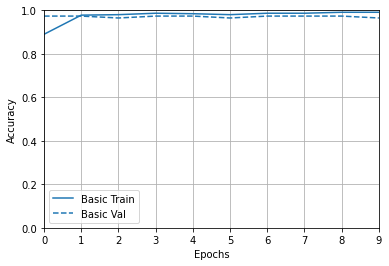

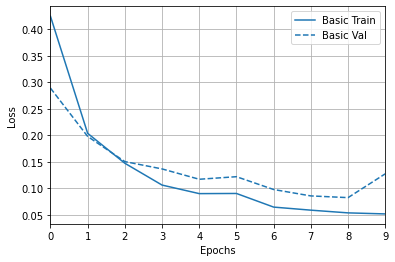

In [172]:

batch_size = 50
epochs = 10
model_3_layers_param = copy.deepcopy(values)
model_3_layers_param["n_neurons"] = 20
#model_3_layers_param["optimizer"] = 'Adam'
#model_3_layers_param["learning_rate"] = param_others["learning_rate"]
model_3_layers_param["regularization"] = tf.keras.regularizers.L2(.01)
model = build_model_n_layer(**model_3_layers_param)
model.summary()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
start = time.time()
history = model.fit(train_x, train_y,
                    epochs=epochs, batch_size=batch_size,  validation_data=(test_x, test_y), shuffle=True,
                    verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots(report_every=10, dot_every=1)])
print('\nTraining MLP completato in %.2f s.' % (time.time() - start))
scoring(train_x, train_y, test_x, test_y,model)
plot(history)

Model: "sequential_359"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1292 (Dense)           (None, 30)                930       
_________________________________________________________________
dense_1287 (Dense)           (None, 20)                620       
_________________________________________________________________
dense_1288 (Dense)           (None, 20)                420       
_________________________________________________________________
dense_1289 (Dense)           (None, 20)                420       
_________________________________________________________________
dense_1290 (Dense)           (None, 20)                420       
_________________________________________________________________
dense_1291 (Dense)           (None, 20)                420       
_________________________________________________________________
dense_1293 (Dense)           (None, 2)              

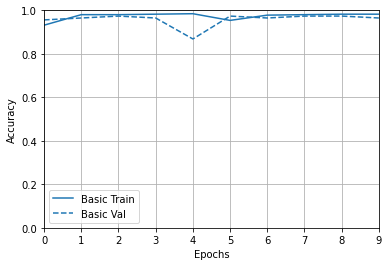

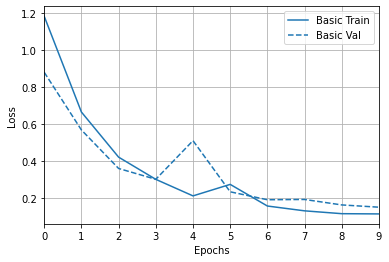

In [193]:
#grandi valori della penalità = alta recall, bassa precisione
#dopo 3 layer nessun miglioramento significativo, SGD regolarizzato leggermente superiore
model_n_layers_param = copy.deepcopy(values)
model_n_layers_param["n_neurons"] = 20
#model_n_layers_param["optimizer"] = 'Adam'
#model_n_layers_param["learning_rate"] = param_others["learning_rate"]
model_n_layers_param["regularization"] = tf.keras.regularizers.L2(.01)
model4 = build_model_n_layer(**model_n_layers_param, n_layers = 5)
model4.summary()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
start = time.time()
history = model4.fit(train_x, train_y,
                    epochs=epochs, batch_size=batch_size,  validation_data=(test_x, test_y), shuffle=True,
                    verbose=0, callbacks=[early_stop, tfdocs.modeling.EpochDots(report_every=10, dot_every=1)])
print('\nTraining MLP completato in %.2f s.' % (time.time() - start))
scoring(train_x, train_y, test_x, test_y, model4)
plot(history)

In [167]:
print(values, '\n')
print(param_others)

{'learning_rate': 0.5, 'momentum': 0.6, 'optimizer': 'SGD', 'init_mode': 'normal', 'activation_hidden': 'tanh', 'activation_output': 'sigmoid', 'n_neurons': 80} 

{'learning_rate': 0.1, 'optimizer': 'Adam'}


In [196]:
def save(values, param_others):
  a_file = open("values.json", "w")
  adam_parameter = open("adam.json", "w")
  json.dump(values, a_file)
  json.dump(param_others, adam_parameter)
  a_file.close()
  adam_parameter.close()



In [197]:
save(values, param_others)

In [50]:
def save_all_weigths(model, model4):
  model.save_weights('my_checkpoint')
  model4.save_weights('my_checkpoint4')
#files.download('saved_weigths/my_weights.data')


In [51]:
def read_values():
  a_file = open("values.json", "r")
  values = json.load(a_file)
  print(values, type(values))